<a href="https://colab.research.google.com/github/dalexsuam/ECG_DEEP_LEARNING/blob/main/Code_01_12_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# Import libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast

import numpy as np
import pandas as pd
import scipy
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
from scipy import io

import os
from typing import List, Tuple, Optional, Dict
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight

import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm

# Constants
SEED = 42
FS = 500  # Sampling frequency
LEAD_II_INDEX = 1  # Index for Lead II (for R-peak detection)
BEAT_LENGTH_SAMPLES = 600  # 600 samples = 1.2 seconds at 500Hz

# HYPERPARAMETERS (updated for beat-based processing)
# Fixed columns
TARGET_COL = 'sport_ability'
ID_COL = 'ECG_patient_id'

# Tabular processing
COLS_TO_SCALE = ['age_at_exam', 'weight', 'height', 'trainning_load']

# K-fold split
N_SPLITS = 5

# Data augmentation parameters
# Using beat morphology (600 samples) instead of 2500-sample windows
BEAT_LENGTH = BEAT_LENGTH_SAMPLES  # 600 samples = 1.2 seconds
STRIDE_TRAIN = BEAT_LENGTH // 2  # 50% overlap for training
STRIDE_VAL = BEAT_LENGTH  # No overlap for validation (use only representative beat)

# Model training
BATCH_SIZE = 32
LEARNING_RATE = 0.0006281996940933472
EPOCHS = 200
PATIENCE = 25
VERBOSE = 10
PCT_START = 0.4580774462774424
BASE_CHANNELS = 32

# Regularization
DROPOUT_RATE = 0.23118012099967702
L1_LAMBDA = 0
L2_LAMBDA = 0.0021296084365636635
LABEL_SMOOTHING = 0.15607306361745482

# Data augmentation (adjusted for beat morphology)
JITTER_STRENGTH = 0.05  # Reduced for beat morphology
CHANNEL_MASK = 0.2  # Reduced probability for beat morphology

In [90]:
from google.colab import drive

drive.mount("/content/drive")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
# ============================================================================
# 1. ECG SIGNAL PROCESSING FUNCTIONS
# ============================================================================

def butter_bandpass(lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter coefficients."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=FS, order=5):
    """Applies a Butterworth bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq=50.0, fs=FS, Q=30):
    """Applies a 50Hz Notch filter to remove powerline noise."""
    nyq = 0.5 * fs
    w0 = notch_freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

def preprocess_signal(ecg: np.ndarray) -> np.ndarray:
    """Applies per-lead Z-score normalization to the already-filtered signal."""
    ecg = ecg.copy()
    for i in range(ecg.shape[1]):
        ecg[:, i] = (ecg[:, i] - np.mean(ecg[:, i])) / (np.std(ecg[:, i]) + 1e-6)
    return ecg

def r_peak_detection_and_segmentation(ecg_12_leads: np.ndarray, fs: int = FS,
                                     return_all_beats: bool = False) -> np.ndarray:
    """
    Detects R-peaks, segments beats, and returns beat morphologies.

    Args:
        ecg_12_leads: Raw ECG signal (n_samples, 12)
        fs: Sampling frequency
        return_all_beats: If True, returns all segmented beats; if False, returns representative beat

    Returns:
        If return_all_beats: Array of shape (n_beats, 12, BEAT_LENGTH_SAMPLES)
        If not: Representative beat of shape (12, BEAT_LENGTH_SAMPLES)
    """
    lead_for_detection = ecg_12_leads[:, LEAD_II_INDEX]

    # Pan-Tompkins inspired R-peak detection
    diff_signal = np.diff(lead_for_detection)**2
    window_size = int(0.150 * fs)  # 150ms window for integration
    integrated_signal = np.convolve(diff_signal, np.ones(window_size)/window_size, mode='same')

    # Peak detection
    distance_min = int(0.3 * fs)  # Minimum 300ms between R-peaks (max HR ~200 bpm)
    peak_threshold = np.max(integrated_signal) * 0.4
    r_peaks_idx, _ = find_peaks(integrated_signal, height=peak_threshold, distance=distance_min)

    # Segment beats around R-peaks
    all_beats = []
    half_beat = BEAT_LENGTH_SAMPLES // 2

    for r_idx in r_peaks_idx:
        start_idx = r_idx - half_beat
        end_idx = r_idx + half_beat

        # Ensure we have enough samples before and after R-peak
        if start_idx >= 0 and end_idx <= ecg_12_leads.shape[0]:
            beat = ecg_12_leads[start_idx:end_idx, :]
            all_beats.append(beat)

    if not all_beats:
        # Return zeros if no beats detected
        if return_all_beats:
            return np.zeros((1, 12, BEAT_LENGTH_SAMPLES), dtype=np.float32)
        else:
            return np.zeros((12, BEAT_LENGTH_SAMPLES), dtype=np.float32)

    # Convert to array: (n_beats, BEAT_LENGTH_SAMPLES, 12)
    segmented_ecg = np.array(all_beats, dtype=np.float32)

    # Transpose to (n_beats, 12, BEAT_LENGTH_SAMPLES)
    segmented_ecg = np.transpose(segmented_ecg, (0, 2, 1))

    if return_all_beats:
        return segmented_ecg
    else:
        # Return representative beat (mean of all beats)
        representative_ecg = np.mean(segmented_ecg, axis=0)
        return representative_ecg

def extract_beat_morphologies(ecg_signal: np.ndarray, fs: int = FS) -> Dict[str, np.ndarray]:
    """
    Extract multiple beat morphologies from ECG signal.

    Returns:
        Dictionary with:
        - 'representative': Mean beat (12, 600)
        - 'median': Median beat (12, 600)
        - 'std': Standard deviation across beats (12, 600)
        - 'all_beats': All segmented beats (n_beats, 12, 600)
    """
    # Get all beats
    all_beats = r_peak_detection_and_segmentation(ecg_signal, fs, return_all_beats=True)

    if len(all_beats) == 0:
        # Return zeros if no beats detected
        zeros = np.zeros((12, BEAT_LENGTH_SAMPLES), dtype=np.float32)
        return {
            'representative': zeros,
            'median': zeros,
            'std': zeros,
            'all_beats': np.zeros((1, 12, BEAT_LENGTH_SAMPLES), dtype=np.float32)
        }

    # Calculate statistics
    representative_beat = np.mean(all_beats, axis=0)
    median_beat = np.median(all_beats, axis=0)
    std_beat = np.std(all_beats, axis=0)

    return {
        'representative': representative_beat,
        'median': median_beat,
        'std': std_beat,
        'all_beats': all_beats
    }

def normalize_instance_wise(signals: np.ndarray) -> np.ndarray:
    """Normalize signals instance-wise (z-score)."""
    # For beat morphologies: (n_samples, channels, seq_len)
    if len(signals.shape) == 3:
        # Reshape to (n_samples, seq_len, channels) for normalization
        signals_reshaped = signals.transpose(0, 2, 1)
        mean = np.mean(signals_reshaped, axis=1, keepdims=True)
        std = np.std(signals_reshaped, axis=1, keepdims=True)
        epsilon = 1e-8
        normalized = (signals_reshaped - mean) / (std + epsilon)
        return normalized.transpose(0, 2, 1)
    else:
        # For regular signals: (n_samples, seq_len, channels)
        mean = np.mean(signals, axis=1, keepdims=True)
        std = np.std(signals, axis=1, keepdims=True)
        epsilon = 1e-8
        return (signals - mean) / (std + epsilon)

def build_sequences_from_beats(signals: np.ndarray, tabular: np.ndarray, labels: np.ndarray,
                              window: int = BEAT_LENGTH_SAMPLES, stride: int = BEAT_LENGTH_SAMPLES,
                              use_multiple_beats: bool = True, max_beats_per_patient: int = 10) -> Tuple:
    """
    Build sequences from beat morphologies.

    Args:
        signals: Array of shape (n_patients, 12, BEAT_LENGTH_SAMPLES) - representative beats
        use_multiple_beats: If True, use multiple beats per patient; if False, use only representative
        max_beats_per_patient: Maximum number of beats to use per patient
    """
    X_sig_seq = []
    X_tab_seq = []
    y_seq = []
    id_seq = []

    num_patients = signals.shape[0]

    for i in range(num_patients):
        curr_sig = signals[i]  # Shape: (12, BEAT_LENGTH_SAMPLES) - representative beat

        # If we have all beats stored separately, use them
        if use_multiple_beats and hasattr(signals, 'all_beats_per_patient'):
            # Get all beats for this patient
            all_beats = signals.all_beats_per_patient[i]
            n_beats = min(len(all_beats), max_beats_per_patient)

            # Use multiple beats
            for beat_idx in range(n_beats):
                beat = all_beats[beat_idx]  # Shape: (12, BEAT_LENGTH_SAMPLES)
                X_sig_seq.append(beat)
                X_tab_seq.append(tabular[i])
                y_seq.append(labels[i])
                id_seq.append(i)
        else:
            # Use only representative beat
            X_sig_seq.append(curr_sig)
            X_tab_seq.append(tabular[i])
            y_seq.append(labels[i])
            id_seq.append(i)

    # Convert to arrays and reshape for CNN input
    # CNN expects: (batch, channels, seq_len)
    X_sig_seq = np.array(X_sig_seq)  # Already (n_samples, 12, BEAT_LENGTH_SAMPLES)

    return np.array(X_sig_seq), np.array(X_tab_seq), np.array(y_seq), np.array(id_seq)

In [92]:
# ============================================================================
# 2. TABULAR FEATURE ENGINEERING AND PROCESSING
# ============================================================================

def tabular_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Creates BMI and BSA, and cleans initial outliers."""
    df = df.copy()

    # Clean age outliers
    df.loc[(df['age_at_exam'] < 0.0) | (df['age_at_exam'] > 100.0), 'age_at_exam'] = np.nan

    # Clean training load outliers
    df.loc[(df['trainning_load'] <= 0.0) | (df['trainning_load'] > 4.0), 'trainning_load'] = np.nan

    # Create BMI and BSA
    df['height_m'] = df['height'] / 100.0
    df['BMI'] = df['weight'] / (df['height_m']**2)
    df['BSA'] = np.sqrt((df['height'] * df['weight']) / 3600.0)

    # Drop columns
    df = df.drop(columns=['height', 'height_m', 'AV block', 'ST abnormality', 'Complete BBB',
                          'Prolonged QTc', 'Uncontrolled hypertension', 'Supraventricular arrhythmias',
                          'Ventricular arrhythmias', 'Baseline ECG abnormalities', 'Valvular heart diseases',
                          'Symptomatic patients'])

    return df

class TabularProcessor:
    """Handles Iterative Imputation, StandardScaler, and OneHotEncoder."""
    def __init__(self, numerical_features: List[str], categorical_features: List[str]):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.imputer = IterativeImputer(max_iter=10, random_state=SEED)
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, df: pd.DataFrame):
        """Fit the processor on training data."""
        numerical_data_train = df[self.numerical_features].values
        self.imputer.fit(numerical_data_train)

        imputed_data_train = self.imputer.transform(numerical_data_train)
        self.scaler.fit(imputed_data_train)

        categorical_data_train = df[self.categorical_features].astype(str).values
        self.encoder.fit(categorical_data_train)

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Transform the data."""
        numerical_data = df[self.numerical_features].values
        imputed_data = self.imputer.transform(numerical_data)
        scaled_data = self.scaler.transform(imputed_data)

        categorical_data = df[self.categorical_features].astype(str).values
        encoded_data = self.encoder.transform(categorical_data)

        return np.concatenate([scaled_data, encoded_data], axis=1)

In [93]:
# ============================================================================
# 3. DATA LOADING AND PREPROCESSING WITH BEAT MORPHOLOGIES (FIXED)
# ============================================================================

def load_and_preprocess_data_with_beats(path: str,
                                       use_multiple_beats: bool = False,
                                       max_beats_per_patient: int = 10) -> Tuple:
    """
    Load and preprocess ECG signals to extract beat morphologies.

    Args:
        use_multiple_beats: If True, store all beats for each patient
        max_beats_per_patient: Maximum number of beats to store per patient
    """
    print("Loading data and extracting beat morphologies...")

    # Load tabular data
    tabular_data = pd.read_excel(os.path.join(path, "VALETUDO_database_1st_batch_en_all_info.xlsx"))
    tabular_data_2batch = pd.read_excel(os.path.join(path, "VALETUDO_database_2nd_batch_en_all_info.xlsx"))

    # Combine tabular data
    tabular_data = pd.concat([
        tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
        tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
    ], ignore_index=True)

    # Feature engineering
    tabular_data = tabular_feature_engineering(tabular_data)

    # Define features
    numerical_features = ['age_at_exam', 'weight', 'BMI', 'BSA', 'trainning_load']
    categorical_features = ['sex', 'sport_classification']

    # Process tabular data
    processor = TabularProcessor(numerical_features, categorical_features)
    processor.fit(tabular_data)
    tabular_processed = processor.transform(tabular_data)

    # Load ECG signals
    ecg_folder_1 = os.path.join(path, "1_batch_extracted")
    ecg_folder_2 = os.path.join(path, "2_batch_extracted")

    ecg_files_1 = [f for f in os.listdir(ecg_folder_1) if f.endswith(".mat")]
    ecg_files_2 = [f for f in os.listdir(ecg_folder_2) if f.endswith(".mat")]

    def extract_patient_id(filename):
        return int(filename.split(".")[0])

    ecg_files_1.sort(key=extract_patient_id)
    ecg_files_2.sort(key=extract_patient_id)

    all_representative_beats = []
    all_tabular_processed = []
    all_labels = []
    all_beats_per_patient = []  # Store all beats if use_multiple_beats is True
    all_patient_ids = []

    print("Processing ECG signals and extracting beat morphologies...")

    # Process first batch
    for ecg_path in tqdm(ecg_files_1, desc="Batch 1"):
        filepath = os.path.join(ecg_folder_1, ecg_path)
        matdata = scipy.io.loadmat(filepath)
        ecg = matdata['val']  # Shape: (5000, 12)

        # Apply filters
        ecg_filtered = ecg.copy()
        for i in range(12):
            ecg_filtered[:, i] = ecg_filtered[:, i] - np.mean(ecg_filtered[:, i])  # Center to 0
            ecg_filtered[:, i] = apply_bandpass_filter(ecg_filtered[:, i])
            ecg_filtered[:, i] = notch_filter(ecg_filtered[:, i])

        # Extract beat morphologies
        beat_morphologies = extract_beat_morphologies(ecg_filtered)

        all_representative_beats.append(beat_morphologies['representative'])

        if use_multiple_beats:
            # Store all beats (up to max_beats_per_patient)
            all_beats = beat_morphologies['all_beats']
            n_beats = min(len(all_beats), max_beats_per_patient)
            all_beats_per_patient.append(all_beats[:n_beats])

        # Get patient ID from filename
        pid = extract_patient_id(ecg_path)
        all_patient_ids.append(pid)

    # Process second batch
    for ecg_path in tqdm(ecg_files_2, desc="Batch 2"):
        filepath = os.path.join(ecg_folder_2, ecg_path)
        matdata = scipy.io.loadmat(filepath)
        ecg = matdata['val']  # Shape: (5000, 12)

        # Apply filters
        ecg_filtered = ecg.copy()
        for i in range(12):
            ecg_filtered[:, i] = ecg_filtered[:, i] - np.mean(ecg_filtered[:, i])  # Center to 0
            ecg_filtered[:, i] = apply_bandpass_filter(ecg_filtered[:, i])
            ecg_filtered[:, i] = notch_filter(ecg_filtered[:, i])

        # Extract beat morphologies
        beat_morphologies = extract_beat_morphologies(ecg_filtered)

        all_representative_beats.append(beat_morphologies['representative'])

        if use_multiple_beats:
            # Store all beats (up to max_beats_per_patient)
            all_beats = beat_morphologies['all_beats']
            n_beats = min(len(all_beats), max_beats_per_patient)
            all_beats_per_patient.append(all_beats[:n_beats])

        # Get patient ID from filename
        pid = extract_patient_id(ecg_path)
        all_patient_ids.append(pid)

    # Convert to numpy arrays
    signals_array = np.array(all_representative_beats)  # Shape: (n_patients, 12, 600)

    # Extract labels
    labels_array = tabular_data[TARGET_COL].values

    print(f"\nData shapes:")
    print(f"  Representative beats: {signals_array.shape}")
    print(f"  Tabular features: {tabular_processed.shape}")
    print(f"  Labels: {labels_array.shape}")

    # Normalize signals
    signals_normalized = normalize_instance_wise(signals_array)

    # Return as a dictionary if using multiple beats
    if use_multiple_beats:
        return {
            'signals': signals_normalized,
            'tabular': tabular_processed,
            'labels': labels_array,
            'patient_ids': np.array(all_patient_ids),
            'all_beats_per_patient': all_beats_per_patient
        }
    else:
        return signals_normalized, tabular_processed, labels_array, np.array(all_patient_ids)

In [94]:
# ============================================================================
# 4. DATASET AND DATALOADER FOR BEAT MORPHOLOGIES
# ============================================================================

class ECGBeatDataset(Dataset):
    """Dataset for beat morphologies."""
    def __init__(self, signals: np.ndarray, tabular: np.ndarray, labels: Optional[np.ndarray] = None,
                 is_train: bool = False, jitter_strength: float = 0.0, channel_mask: float = 0.0,
                 time_warping: bool = True):
        """
        Dataset for beat morphologies.

        Args:
            signals: (N, 12, BEAT_LENGTH) beat morphologies
            tabular: (N, tabular_features)
            labels: (N,) optional labels
            is_train: whether to apply augmentations
            jitter_strength: strength of jitter augmentation
            channel_mask: probability of channel masking
            time_warping: whether to apply time warping augmentation
        """
        self.signals = torch.tensor(signals, dtype=torch.float32)  # Already (N, channels, seq_len)
        self.tabular = torch.tensor(tabular, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

        self.is_train = is_train
        self.jitter_strength = jitter_strength
        self.channel_mask_prob = channel_mask
        self.time_warping = time_warping
        self.seq_len = signals.shape[2]
        self.n_channels = signals.shape[1]

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        beat_sig = self.signals[idx].clone()  # Shape: (12, BEAT_LENGTH)

        if self.is_train:
            # Time warping (stretching/shrinking)
            if self.time_warping and torch.rand(1) < 0.3:
                # Random time warping factor
                warp_factor = 0.8 + 0.4 * torch.rand(1).item()  # Between 0.8 and 1.2
                new_length = int(self.seq_len * warp_factor)

                # Resample the signal
                beat_sig_resampled = F.interpolate(
                    beat_sig.unsqueeze(0),
                    size=new_length,
                    mode='linear',
                    align_corners=False
                ).squeeze(0)

                # Pad or crop to original length
                if new_length > self.seq_len:
                    beat_sig = beat_sig_resampled[:, :self.seq_len]
                else:
                    padding = torch.zeros((self.n_channels, self.seq_len - new_length),
                                         dtype=beat_sig.dtype, device=beat_sig.device)
                    beat_sig = torch.cat([beat_sig_resampled, padding], dim=1)

            # Jitter (additive noise) - reduced for beat morphology
            if self.jitter_strength > 0:
                noise = torch.randn_like(beat_sig) * self.jitter_strength
                beat_sig = beat_sig + noise

            # Channel masking - reduced probability
            if self.channel_mask_prob > 0 and torch.rand(1) < self.channel_mask_prob:
                mask_idx = torch.randint(0, self.n_channels, (1,)).item()
                beat_sig[mask_idx, :] = 0

        # Split into branches (limb leads vs precordial leads)
        limb_sig = beat_sig[:6, :]      # Limb leads (I, II, III, aVR, aVL, aVF)
        prec_sig = beat_sig[6:, :]      # Precordial leads (V1-V6)
        tab_data = self.tabular[idx]

        if self.labels is not None:
            return limb_sig, prec_sig, tab_data, self.labels[idx]
        else:
            return limb_sig, prec_sig, tab_data

def make_loader(dataset: Dataset, batch_size: int, shuffle: bool, drop_last: bool = False) -> DataLoader:
    """Create DataLoader with appropriate settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=2,
    )


In [95]:
# ============================================================================
# 5. MODEL ARCHITECTURE (ADJUSTED FOR BEAT MORPHOLOGIES)
# ============================================================================

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block for channel attention."""
    def __init__(self, channel: int, reduction: int = 4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class MicroResNetBlock(nn.Module):
    """Micro ResNet block with SE attention."""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 7, stride: int = 1):
        super(MicroResNetBlock, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                              stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.se = SEBlock(out_channels, reduction=4)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride > 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += residual
        out = self.relu(out)

        return out

class ThreeBranchBeatCNN(nn.Module):
    """3-Branch CNN for beat morphology classification."""
    def __init__(self, n_tabular_features: int, n_classes: int = 2,
                 dropout: float = 0.5, base_channels: int = 32):
        super(ThreeBranchBeatCNN, self).__init__()

        c1 = base_channels
        c2 = base_channels * 2
        c3 = base_channels * 4

        # Adjusted for 600-sample beat length (vs 2500 in original)
        def make_resnet_branch():
            """Create ResNet branch for beat morphology processing."""
            return nn.Sequential(
                MicroResNetBlock(in_channels=6, out_channels=c1, kernel_size=15, stride=1),
                nn.MaxPool1d(2),  # 600 -> 300
                MicroResNetBlock(in_channels=c1, out_channels=c2, kernel_size=7, stride=2),
                nn.MaxPool1d(2),  # 300 -> 150
                MicroResNetBlock(in_channels=c2, out_channels=c3, kernel_size=5, stride=2),
                nn.AdaptiveAvgPool1d(1)  # 150 -> 1
            )

        # Two branches for ECG beat morphologies
        self.branch_limb = make_resnet_branch()  # Limb leads
        self.branch_prec = make_resnet_branch()  # Precordial leads

        # Branch for tabular data
        self.branch_tab = nn.Sequential(
            nn.Linear(n_tabular_features, c2),
            nn.BatchNorm1d(c2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

        # Fusion and classification
        fusion_dim = c3 + c3 + c2

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, c3 * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(c3 * 2, n_classes)
        )

    def forward(self, limb: torch.Tensor, prec: torch.Tensor, tab: torch.Tensor) -> torch.Tensor:
        # Process limb leads
        x_limb = self.branch_limb(limb).squeeze(-1)  # (batch, c3)

        # Process precordial leads
        x_prec = self.branch_prec(prec).squeeze(-1)  # (batch, c3)

        # Process tabular data
        x_tab = self.branch_tab(tab)  # (batch, c2)

        # Concatenate all features
        combined = torch.cat([x_limb, x_prec, x_tab], dim=1)

        # Final classification
        return self.classifier(combined)


In [96]:
# ============================================================================
# 6. TRAINING AND VALIDATION FUNCTIONS
# ============================================================================

def train_one_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module,
                   optimizer: optim.Optimizer, scheduler: Optional[optim.lr_scheduler._LRScheduler],
                   scaler: torch.amp.GradScaler, device: torch.device,
                   l1_lambda: float = 0.0, l2_lambda: float = 0.0) -> Tuple[float, float]:
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    for limb_in, prec_in, tab_in, targets in train_loader:
        limb_in = limb_in.to(device)
        prec_in = prec_in.to(device)
        tab_in = tab_in.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=device_type, enabled=(device.type == 'cuda')):
            logits = model(limb_in, prec_in, tab_in)
            loss = criterion(logits, targets)

            # L1 regularization
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss += l1_lambda * l1_norm

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * targets.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds),
                        average='weighted')

    return epoch_loss, epoch_f1

def validate_one_epoch(model: nn.Module, val_loader: DataLoader, criterion: nn.Module,
                      device: torch.device) -> Tuple[float, float, np.ndarray]:
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []

    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    with torch.no_grad():
        for limb_in, prec_in, tab_in, targets in val_loader:
            limb_in = limb_in.to(device)
            prec_in = prec_in.to(device)
            tab_in = tab_in.to(device)
            targets = targets.to(device).long()

            with autocast(device_type=device_type, enabled=(device.type == 'cuda')):
                logits = model(limb_in, prec_in, tab_in)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds = logits.argmax(dim=1)
            probs = torch.softmax(logits, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds),
                        average='weighted')

    return epoch_loss, epoch_f1, np.concatenate(all_probs)

def fit(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
        epochs: int, criterion: nn.Module, optimizer: optim.Optimizer,
        scheduler: Optional[optim.lr_scheduler._LRScheduler], scaler: torch.amp.GradScaler,
        device: torch.device, l1_lambda: float = 0.0, l2_lambda: float = 0.0,
        patience: int = 0, evaluation_metric: str = "val_f1", mode: str = 'max',
        restore_best_weights: bool = True, verbose: int = 1,
        experiment_name: str = "best_model") -> Tuple[nn.Module, dict]:
    """Main training loop with early stopping."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Start Training: {epochs} epochs on {device}...\n")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, scaler,
            device, l1_lambda, l2_lambda
        )

        val_loss, val_f1, _ = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} F1: {val_f1:.4f} | "
                  f"LR: {current_lr:.6f}")

        # Early stopping
        if patience > 0:
            current_metric = val_f1 if evaluation_metric == "val_f1" else val_loss

            if mode == 'max':
                is_improvement = current_metric > best_metric
            else:
                is_improvement = current_metric < best_metric

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), f"{experiment_name}.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes.")

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(f"{experiment_name}.pt", map_location=device))
        print(f"Recovered best model: Epoch {best_epoch} with {evaluation_metric}: {best_metric:.4f}")

    return model, training_history


In [97]:
# ============================================================================
# 7. K-FOLD CROSS VALIDATION PIPELINE FOR BEAT MORPHOLOGIES (FIXED)
# ============================================================================

def run_kfold_cross_validation_with_beats(data_dict: dict,
                                         use_multiple_beats: bool = False,
                                         n_splits: int = 5, model_dir: str = "./") -> dict:
    """Run K-fold cross validation with beat morphologies."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Extract data from dictionary if using multiple beats
    if use_multiple_beats:
        X_signals = data_dict['signals']
        X_tabular = data_dict['tabular']
        y = data_dict['labels']
        patient_ids = data_dict['patient_ids']
        all_beats_per_patient = data_dict['all_beats_per_patient']
    else:
        X_signals, X_tabular, y, patient_ids = data_dict
        all_beats_per_patient = None

    # Initialize k-fold
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    # Results storage
    fold_results = {
        'histories': [],
        'roc_data': [],
        'fold_scores': [],
        'oof_probs': [],
        'oof_targets': []
    }

    print(f"\nStarting {n_splits}-fold cross-validation with beat morphologies...")
    print(f"Using {'multiple beats' if use_multiple_beats else 'representative beat only'}")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_signals, y)):
        print(f"\n{'='*40} FOLD {fold+1}/{n_splits} {'='*40}")

        # Split data
        X_sig_train_fold = X_signals[train_idx]
        X_tab_train_fold = X_tabular[train_idx]
        y_train_fold = y[train_idx]

        X_sig_val_fold = X_signals[val_idx]
        X_tab_val_fold = X_tabular[val_idx]
        y_val_fold = y[val_idx]
        patient_ids_val = patient_ids[val_idx]

        # Build sequences from beats
        if use_multiple_beats:
            # Custom function to handle multiple beats
            X_sig_train_seq, X_tab_train_seq, y_train_seq, ids_train_seq = build_sequences_with_multiple_beats(
                X_sig_train_fold, X_tab_train_fold, y_train_fold,
                [all_beats_per_patient[i] for i in train_idx]
            )
        else:
            X_sig_train_seq, X_tab_train_seq, y_train_seq, ids_train_seq = build_sequences_from_beats(
                X_sig_train_fold, X_tab_train_fold, y_train_fold,
                use_multiple_beats=False
            )

        X_sig_val_seq, X_tab_val_seq, y_val_seq, ids_val_seq = build_sequences_from_beats(
            X_sig_val_fold, X_tab_val_fold, y_val_fold,
            use_multiple_beats=False  # For validation, use only representative beat
        )

        print(f"  Training samples: {len(y_train_seq)}")
        print(f"  Validation samples: {len(y_val_seq)}")

        # Create datasets
        train_dataset = ECGBeatDataset(
            X_sig_train_seq, X_tab_train_seq, y_train_seq,
            is_train=True, jitter_strength=JITTER_STRENGTH,
            channel_mask=CHANNEL_MASK, time_warping=True
        )

        val_dataset = ECGBeatDataset(
            X_sig_val_seq, X_tab_val_seq, y_val_seq, is_train=False
        )

        # Create data loaders
        train_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
        val_loader = make_loader(val_dataset, BATCH_SIZE, shuffle=False)

        # Initialize model
        n_tab_features = X_tabular.shape[1]
        model = ThreeBranchBeatCNN(
            n_tabular_features=n_tab_features,
            n_classes=2,
            dropout=DROPOUT_RATE,
            base_channels=BASE_CHANNELS
        ).to(device)

        # Class weights for imbalanced data
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=LABEL_SMOOTHING
        )

        # Optimizer and scheduler
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS,
            pct_start=PCT_START
        )

        scaler = torch.amp.GradScaler('cuda')

        # Train
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            scaler=scaler,
            device=device,
            l1_lambda=L1_LAMBDA,
            l2_lambda=L2_LAMBDA,
            patience=PATIENCE,
            experiment_name=f"{model_dir}/fold_{fold+1}_model",
            verbose=VERBOSE
        )

        # Validation
        _, _, val_probs = validate_one_epoch(model, val_loader, criterion, device)

        # Patient-level aggregation (average predictions for patients with multiple beats)
        df_val_results = pd.DataFrame({
            'patient_id': patient_ids_val[ids_val_seq],
            'prob_1': val_probs[:, 1],
            'target': y_val_seq
        })

        # Average probabilities per patient
        patient_predictions = df_val_results.groupby('patient_id').agg({
            'prob_1': 'mean',
            'target': 'first'
        }).reset_index()

        # Calculate patient-level metrics
        y_true_patient = patient_predictions['target'].values
        y_pred_patient = (patient_predictions['prob_1'].values > 0.5).astype(int)

        patient_f1 = f1_score(y_true_patient, y_pred_patient, average='weighted')
        patient_acc = accuracy_score(y_true_patient, y_pred_patient)

        # Store results
        fold_results['histories'].append(history)
        fold_results['roc_data'].append({
            'true': y_true_patient,
            'prob': patient_predictions['prob_1'].values
        })
        fold_results['fold_scores'].append(patient_f1)
        fold_results['oof_probs'].extend(patient_predictions['prob_1'].values)
        fold_results['oof_targets'].extend(y_true_patient)

        print(f"\nFold {fold+1} Results:")
        print(f"  Patient-level F1: {patient_f1:.4f}")
        print(f"  Patient-level Accuracy: {patient_acc:.4f}")

        # Clean up
        del model, train_dataset, val_dataset, train_loader, val_loader
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Calculate overall metrics
    oof_probs = np.array(fold_results['oof_probs'])
    oof_targets = np.array(fold_results['oof_targets'])
    oof_preds = (oof_probs > 0.5).astype(int)

    overall_f1 = f1_score(oof_targets, oof_preds, average='weighted')
    overall_acc = accuracy_score(oof_targets, oof_preds)
    overall_auc = roc_auc_score(oof_targets, oof_probs)

    print(f"\n{'='*50}")
    print(f"OVERALL CROSS-VALIDATION RESULTS:")
    print(f"  Mean F1: {np.mean(fold_results['fold_scores']):.4f} ± {np.std(fold_results['fold_scores']):.4f}")
    print(f"  Overall F1: {overall_f1:.4f}")
    print(f"  Overall Accuracy: {overall_acc:.4f}")
    print(f"  Overall AUC: {overall_auc:.4f}")
    print(f"{'='*50}")

    return fold_results


In [98]:
# ============================================================================
# 8. VISUALIZATION FUNCTIONS (ENHANCED)
# ============================================================================

def plot_kfold_results(fold_results: dict):
    """Plot training history and ROC curves from K-fold CV."""
    histories = fold_results['histories']
    roc_data = fold_results['roc_data']

    if not histories:
        print("No training history to plot")
        return

    n_folds = len(histories)
    colors = plt.cm.tab10(np.linspace(0, 1, n_folds))

    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(3, 2)

    # Plot training/validation loss
    ax_tl = fig.add_subplot(gs[0, 0])
    ax_vl = fig.add_subplot(gs[0, 1])

    for i, h in enumerate(histories):
        ax_tl.plot(h['train_loss'], color=colors[i], lw=2, alpha=0.8, label=f'Fold {i+1}')
        ax_vl.plot(h['val_loss'], color=colors[i], lw=2, alpha=0.8, label=f'Fold {i+1}')

    ax_tl.set_title('Training Loss (All Folds)', fontsize=14)
    ax_tl.set_xlabel('Epochs')
    ax_tl.set_ylabel('Loss')
    ax_tl.legend()
    ax_tl.grid(True, alpha=0.3)

    ax_vl.set_title('Validation Loss (All Folds)', fontsize=14)
    ax_vl.set_xlabel('Epochs')
    ax_vl.set_ylabel('Loss')
    ax_vl.legend()
    ax_vl.grid(True, alpha=0.3)

    # Plot training/validation F1
    ax_tf = fig.add_subplot(gs[1, 0])
    ax_vf = fig.add_subplot(gs[1, 1])

    for i, h in enumerate(histories):
        ax_tf.plot(h['train_f1'], color=colors[i], lw=2, alpha=0.8, label=f'Fold {i+1}')
        ax_vf.plot(h['val_f1'], color=colors[i], lw=2, alpha=0.8, label=f'Fold {i+1}')

    ax_tf.set_title('Training F1 Score (All Folds)', fontsize=14)
    ax_tf.set_xlabel('Epochs')
    ax_tf.set_ylabel('F1 Score')
    ax_tf.legend()
    ax_tf.grid(True, alpha=0.3)

    ax_vf.set_title('Validation F1 Score (All Folds)', fontsize=14)
    ax_vf.set_xlabel('Epochs')
    ax_vf.set_ylabel('F1 Score')
    ax_vf.legend()
    ax_vf.grid(True, alpha=0.3)

    # Plot ROC curves
    ax_roc = fig.add_subplot(gs[2, :])
    ax_roc.plot([0, 1], [0, 1], linestyle=':', lw=2, color='black', alpha=0.5)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    for i, data in enumerate(roc_data):
        fpr, tpr, _ = roc_curve(data['true'], data['prob'])
        roc_auc = auc(fpr, tpr)

        ax_roc.plot(fpr, tpr, color=colors[i], lw=2, alpha=0.6,
                   label=f'Fold {i+1} (AUC = {roc_auc:.3f})')

        mean_tpr += np.interp(mean_fpr, fpr, tpr)

    if roc_data:  # Check if we have data
        mean_tpr /= n_folds
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        ax_roc.plot(mean_fpr, mean_tpr, color='black', linestyle='-', lw=3,
                   label=f'Mean ROC (AUC = {mean_auc:.3f})')

    ax_roc.set_title('ROC Curves (Patient Level)', fontsize=14)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right", fontsize='small')
    ax_roc.grid(True, alpha=0.3)

    plt.suptitle(f'K-Fold Cross-Validation Analysis ({n_folds} Folds)', fontsize=20, y=0.92)
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

def plot_advanced_metrics(y_true: np.ndarray, y_prob: np.ndarray):
    """Plot calibration curve and precision-recall curve."""
    if len(y_true) == 0 or len(y_prob) == 0:
        print("No data for advanced metrics")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Calibration curve
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        axes[0].plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
        axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
        axes[0].set_xlabel('Confidence')
        axes[0].set_ylabel('True Positives')
        axes[0].set_title('Calibration Curve (Reliability)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    except Exception as e:
        axes[0].text(0.5, 0.5, f'Calibration Error:\n{str(e)}',
                    ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Calibration Curve (Error)')

    # Precision-Recall curve
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        avg_prec = average_precision_score(y_true, y_prob)

        axes[1].plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_prec:.3f}')
        axes[1].set_xlabel('Recall (Sensitivity)')
        axes[1].set_ylabel('Precision (PPV)')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    except Exception as e:
        axes[1].text(0.5, 0.5, f'PR Curve Error:\n{str(e)}',
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Precision-Recall Curve (Error)')

    plt.tight_layout()
    plt.show()

def plot_test_results(y_true: np.ndarray, y_prob: np.ndarray, y_pred: np.ndarray,
                     patient_predictions: pd.DataFrame):
    """Plot comprehensive test set results."""
    if len(y_true) == 0:
        print("No test data to plot")
        return

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))

    # 1. Confusion Matrix
    ax1 = plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title('Confusion Matrix')

    # 2. ROC Curve
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)

    # 3. Precision-Recall Curve
    ax3 = plt.subplot(2, 3, 3)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_prec = average_precision_score(y_true, y_prob)
    ax3.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_prec:.3f}')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.legend(loc="upper right")
    ax3.grid(True, alpha=0.3)

    # 4. Probability Distribution
    ax4 = plt.subplot(2, 3, 4)
    for class_label in [0, 1]:
        class_probs = y_prob[y_true == class_label]
        if len(class_probs) > 0:
            ax4.hist(class_probs, bins=20, alpha=0.6, label=f'Class {class_label}',
                    density=True)
    ax4.set_xlabel('Predicted Probability (Class 1)')
    ax4.set_ylabel('Density')
    ax4.set_title('Probability Distribution by True Class')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Calibration Curve
    ax5 = plt.subplot(2, 3, 5)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    ax5.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax5.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal', alpha=0.5)
    ax5.set_xlabel('Mean Predicted Probability')
    ax5.set_ylabel('Fraction of Positives')
    ax5.set_title('Calibration Curve')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Patient-level predictions
    ax6 = plt.subplot(2, 3, 6)
    patient_predictions_sorted = patient_predictions.sort_values('prob_1')
    colors = ['red' if target == 0 else 'green' for target in patient_predictions_sorted['target']]
    ax6.bar(range(len(patient_predictions_sorted)), patient_predictions_sorted['prob_1'],
            color=colors, alpha=0.6)
    ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    ax6.set_xlabel('Patients (sorted by probability)')
    ax6.set_ylabel('Predicted Probability (Class 1)')
    ax6.set_title('Patient Predictions\n(Red=Class 0, Green=Class 1)')
    ax6.set_ylim([0, 1])
    ax6.grid(True, alpha=0.3)

    plt.suptitle('Test Set Evaluation Results', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

    # Print metrics in a nice format
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE METRICS")
    print("="*60)

    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Create metrics table
    metrics_df = pd.DataFrame({
        'Metric': ['F1 Score', 'Accuracy', 'ROC AUC', 'Precision', 'Recall'],
        'Value': [f'{f1:.4f}', f'{acc:.4f}', f'{roc_auc:.4f}', f'{precision:.4f}', f'{recall:.4f}']
    })

    print(metrics_df.to_string(index=False))

    # Class distribution
    print(f"\nClass Distribution:")
    for class_label in [0, 1]:
        count = np.sum(y_true == class_label)
        percentage = count / len(y_true) * 100
        print(f"  Class {class_label}: {count} patients ({percentage:.1f}%)")


In [99]:

# ============================================================================
# 9. MAIN EXECUTION PIPELINE WITH BEAT MORPHOLOGIES
# ============================================================================

def main_with_beats(use_multiple_beats: bool = True):
    """Main execution pipeline with beat morphologies."""
    # Set paths
    PATH = "/content/drive/MyDrive/WP_02_data/"  # Update this path
    model_dir = "./models_beat"

    # Create model directory
    os.makedirs(model_dir, exist_ok=True)

    # Load and preprocess data with beat extraction
    print("Loading data and extracting beat morphologies...")
    X_signals, X_tabular, y, patient_ids = load_and_preprocess_data_with_beats(
        PATH, use_multiple_beats=use_multiple_beats
    )

    # Print class distribution
    print(f"\nClass distribution:")
    print(f"  Class 0: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
    print(f"  Class 1: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

    # Print beat morphology information
    print(f"\nBeat morphology shapes:")
    print(f"  Input signals: {X_signals.shape} (patients × channels × samples)")
    print(f"  Each beat: {X_signals.shape[1]} channels × {X_signals.shape[2]} samples")
    print(f"  Duration: {X_signals.shape[2]/FS:.2f} seconds per beat")

    # Run K-fold cross-validation with beat morphologies
    fold_results = run_kfold_cross_validation_with_beats(
        X_signals, X_tabular, y, patient_ids,
        use_multiple_beats=use_multiple_beats,
        n_splits=N_SPLITS, model_dir=model_dir
    )

    # Plot results
    plot_kfold_results(fold_results)

    # Plot advanced metrics on OOF predictions
    plot_advanced_metrics(
        np.array(fold_results['oof_targets']),
        np.array(fold_results['oof_probs'])
    )

    print(f"\nTraining with beat morphologies completed successfully!")
    print(f"Mode: {'Multiple beats per patient' if use_multiple_beats else 'Representative beat only'}")

In [100]:
# ============================================================================
# 10. ENSEMBLE AVERAGING AND TEST SET EVALUATION (ENHANCED)
# ============================================================================

def evaluate_test_set_with_ensemble_enhanced(test_data, use_multiple_beats: bool,
                                           n_splits: int, model_dir: str,
                                           best_threshold: float = 0.5):
    """Enhanced test set evaluation with full visualizations."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print("TEST SET EVALUATION WITH ENSEMBLE AVERAGING")
    print(f"{'='*60}")

    # Extract test data
    if use_multiple_beats:
        X_signals_test = test_data['signals']
        X_tabular_test = test_data['tabular']
        y_test = test_data['labels']
        patient_ids_test = test_data['patient_ids']
    else:
        X_signals_test, X_tabular_test, y_test, patient_ids_test = test_data

    # Build sequences from test beats (representative only for test)
    X_sig_test_seq, X_tab_test_seq, y_test_seq, ids_test_seq = build_sequences_from_beats(
        X_signals_test, X_tabular_test, y_test,
        use_multiple_beats=False  # For test, use only representative beat
    )

    print(f"Test dataset: {len(y_test_seq)} segments from {len(np.unique(patient_ids_test))} patients")

    # Create test dataset and loader
    test_dataset = ECGBeatDataset(
        X_sig_test_seq, X_tab_test_seq, y_test_seq, is_train=False
    )

    test_loader = make_loader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # PREDICTION LOOP (ENSEMBLE)
    all_models_probs = np.zeros((len(y_test_seq), n_splits))

    print(f"\nLoading {n_splits} trained models for ensemble...")

    for fold_idx in range(n_splits):
        model_path = os.path.join(model_dir, f"fold_{fold_idx+1}_model.pt")

        # Create empty model
        n_tab_features = X_tabular_test.shape[1]
        model, _ = get_model_optimizer(
            device, n_tab_features, 2,
            dropout=DROPOUT_RATE, base_channels=BASE_CHANNELS
        )

        # Load saved weights
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"  ✓ Fold {fold_idx+1}: Loaded {model_path}")

            # Get predictions
            probs, _ = get_all_probs(model, test_loader, device)
            all_models_probs[:, fold_idx] = probs
        else:
            print(f"  ✗ Fold {fold_idx+1}: Model not found at {model_path}")

        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # AGGREGATION (SOFT VOTING)
    # Equal weights for all models
    weights = np.ones(n_splits) / n_splits
    print(f"\nEnsemble weights: {weights}")

    # Weighted average across folds for each segment
    avg_probs_segment = np.average(all_models_probs, axis=1, weights=weights)

    # Patient-level aggregation
    df_test_results = pd.DataFrame({
        'ECG_patient_id': patient_ids_test[ids_test_seq],
        'prob_1': avg_probs_segment,
        'target': y_test_seq
    })

    # Average probabilities per patient
    final_patient_preds = df_test_results.groupby('ECG_patient_id').agg({
        'prob_1': 'mean',
        'target': 'first'  # All should be the same for a patient
    }).reset_index()

    # FINAL METRICS
    y_true_final = final_patient_preds['target'].values
    y_prob_final = final_patient_preds['prob_1'].values
    y_pred_final = (y_prob_final > best_threshold).astype(int)

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score

    f1 = f1_score(y_true_final, y_pred_final, average='weighted')
    acc = accuracy_score(y_true_final, y_pred_final)
    roc_auc = roc_auc_score(y_true_final, y_prob_final)
    recall = recall_score(y_true_final, y_pred_final, average='weighted')
    precision = precision_score(y_true_final, y_pred_final, average='weighted')

    print(f"\n{'='*50}")
    print("FINAL RESULTS ON TEST SET")
    print(f"{'='*50}")
    print(f"F1 Score (Weighted):     {f1:.4f}")
    print(f"Accuracy:                {acc:.4f}")
    print(f"Recall (Weighted):       {recall:.4f}")
    print(f"Precision (Weighted):    {precision:.4f}")
    print(f"ROC AUC:                 {roc_auc:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_true_final, y_pred_final,
                               target_names=['Class 0', 'Class 1']))

    # CONFUSION MATRIX
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true_final, y_pred_final)
    cm_df = pd.DataFrame(cm,
                        index=['True Class 0', 'True Class 1'],
                        columns=['Pred Class 0', 'Pred Class 1'])
    print(cm_df)

    # Plot comprehensive results
    plot_test_results(y_true_final, y_prob_final, y_pred_final, final_patient_preds)

    return {
        'y_true': y_true_final,
        'y_prob': y_prob_final,
        'y_pred': y_pred_final,
        'metrics': {
            'f1': f1,
            'accuracy': acc,
            'roc_auc': roc_auc,
            'recall': recall,
            'precision': precision
        },
        'confusion_matrix': cm,
        'patient_predictions': final_patient_preds,
        'all_models_probs': all_models_probs
    }


In [101]:
# ============================================================================
# 11. COMPLETE PIPELINE WITH TRAIN/TEST SPLIT (FINAL VERSION)
# ============================================================================

def complete_pipeline_with_test_split_final(path: str, test_size: float = 0.1,
                                          use_multiple_beats: bool = False):
    """
    Complete pipeline with train/test split, K-fold CV, and test evaluation.
    """
    print("="*60)
    print("COMPLETE ECG CLASSIFICATION PIPELINE")
    print("="*60)

    # 1. Load and preprocess all data
    print("\n1. Loading and preprocessing data...")
    data = load_and_preprocess_data_with_beats(
        path, use_multiple_beats=use_multiple_beats
    )

    # Handle return type based on use_multiple_beats
    if use_multiple_beats:
        X_signals = data['signals']
        X_tabular = data['tabular']
        y = data['labels']
        patient_ids = data['patient_ids']
        all_beats_per_patient = data['all_beats_per_patient']
    else:
        X_signals, X_tabular, y, patient_ids = data
        all_beats_per_patient = None

    # 2. Train/Test split at patient level
    print("\n2. Splitting data into train and test sets...")

    # Get unique patients
    unique_patient_ids = np.unique(patient_ids)

    # Create a mapping from patient_id to its indices
    patient_to_indices = {}
    for i, pid in enumerate(patient_ids):
        if pid not in patient_to_indices:
            patient_to_indices[pid] = []
        patient_to_indices[pid].append(i)

    # Get labels for each patient
    patient_labels = {}
    for pid, indices in patient_to_indices.items():
        patient_labels[pid] = y[indices[0]]  # Take first label

    # Convert to arrays for sklearn split
    unique_patient_ids_arr = np.array(list(patient_to_indices.keys()))
    unique_patient_labels_arr = np.array([patient_labels[pid] for pid in unique_patient_ids_arr])

    # Stratified split
    train_pids, test_pids, train_labels_split, test_labels_split = train_test_split(
        unique_patient_ids_arr,
        unique_patient_labels_arr,
        test_size=test_size,
        stratify=unique_patient_labels_arr,
        random_state=SEED
    )

    print(f"  Training patients: {len(train_pids)}")
    print(f"  Test patients: {len(test_pids)}")

    # 3. Create train and test datasets
    print("\n3. Creating train and test datasets...")

    # Get indices for train and test
    train_indices = []
    for pid in train_pids:
        train_indices.extend(patient_to_indices[pid])

    test_indices = []
    for pid in test_pids:
        test_indices.extend(patient_to_indices[pid])

    # Split the data
    X_signals_train = X_signals[train_indices]
    X_tabular_train = X_tabular[train_indices]
    y_train = y[train_indices]
    patient_ids_train = patient_ids[train_indices]

    X_signals_test = X_signals[test_indices]
    X_tabular_test = X_tabular[test_indices]
    y_test = y[test_indices]
    patient_ids_test = patient_ids[test_indices]

    # Split all_beats_per_patient if using multiple beats
    if use_multiple_beats:
        all_beats_train = [all_beats_per_patient[i] for i in train_indices]
        all_beats_test = [all_beats_per_patient[i] for i in test_indices]
    else:
        all_beats_train = None
        all_beats_test = None

    print(f"  Training samples: {len(y_train)}")
    print(f"  Test samples: {len(y_test)}")

    # 4. Run K-fold cross-validation on training set
    print("\n4. Running K-fold cross-validation on training set...")
    model_dir = "./models_beat_ensemble"
    os.makedirs(model_dir, exist_ok=True)

    # Prepare data for K-fold
    if use_multiple_beats:
        train_data = {
            'signals': X_signals_train,
            'tabular': X_tabular_train,
            'labels': y_train,
            'patient_ids': patient_ids_train,
            'all_beats_per_patient': all_beats_train
        }
    else:
        train_data = (X_signals_train, X_tabular_train, y_train, patient_ids_train)

    fold_results = run_kfold_cross_validation_with_beats(
        train_data, use_multiple_beats=use_multiple_beats,
        n_splits=N_SPLITS, model_dir=model_dir
    )

    # PLOT K-FOLD RESULTS
    print("\nPlotting K-fold cross-validation results...")
    plot_kfold_results(fold_results)

    # Plot advanced metrics on OOF predictions
    print("\nPlotting advanced metrics on out-of-fold predictions...")
    plot_advanced_metrics(
        np.array(fold_results['oof_targets']),
        np.array(fold_results['oof_probs'])
    )

    # 5. Evaluate on test set with ensemble
    print("\n5. Evaluating on test set with ensemble...")

    # Prepare test data
    if use_multiple_beats:
        test_data = {
            'signals': X_signals_test,
            'tabular': X_tabular_test,
            'labels': y_test,
            'patient_ids': patient_ids_test,
            'all_beats_per_patient': all_beats_test
        }
    else:
        test_data = (X_signals_test, X_tabular_test, y_test, patient_ids_test)

    # Evaluate test set with enhanced visualization
    test_results = evaluate_test_set_with_ensemble_enhanced(
        test_data,
        use_multiple_beats=False,  # For test, use representative beat only
        n_splits=N_SPLITS,
        model_dir=model_dir,
        best_threshold=0.5
    )

    # 6. Summary
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("="*60)

    # Cross-validation results summary
    cv_f1_scores = fold_results['fold_scores']
    cv_mean_f1 = np.mean(cv_f1_scores)
    cv_std_f1 = np.std(cv_f1_scores)

    # Test results
    test_f1 = test_results['metrics']['f1']
    test_accuracy = test_results['metrics']['accuracy']

    print(f"\nCROSS-VALIDATION (Training Set):")
    print(f"  Mean F1: {cv_mean_f1:.4f} ± {cv_std_f1:.4f}")
    print(f"  Individual fold F1 scores: {[f'{score:.4f}' for score in cv_f1_scores]}")

    print(f"\nTEST SET RESULTS:")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")

    # Check for overfitting
    f1_diff = cv_mean_f1 - test_f1
    if f1_diff > 0.1:
        print(f"\n⚠️  WARNING: Possible overfitting detected!")
        print(f"   CV F1 ({cv_mean_f1:.4f}) is significantly higher than Test F1 ({test_f1:.4f})")
        print(f"   Difference: {f1_diff:.4f}")
    else:
        print(f"\n✓ Good generalization: Test performance is close to CV performance")
        print(f"  Difference: {f1_diff:.4f}")

    return {
        'fold_results': fold_results,
        'test_results': test_results,
        'train_indices': train_indices,
        'test_indices': test_indices
    }



In [102]:
# ============================================================================
# HELPER FUNCTION FOR MULTIPLE BEATS
# ============================================================================

def build_sequences_with_multiple_beats(signals: np.ndarray, tabular: np.ndarray,
                                       labels: np.ndarray, all_beats_list: List[np.ndarray]) -> Tuple:
    """
    Build sequences using multiple beats per patient.

    Args:
        all_beats_list: List of arrays, each containing beats for a patient
    """
    X_sig_seq = []
    X_tab_seq = []
    y_seq = []
    id_seq = []

    for i in range(len(signals)):
        curr_tab = tabular[i]
        curr_label = labels[i]

        # Get all beats for this patient
        all_beats = all_beats_list[i]

        # Use all available beats
        for beat_idx in range(len(all_beats)):
            beat = all_beats[beat_idx]  # Shape: (12, BEAT_LENGTH_SAMPLES)
            X_sig_seq.append(beat)
            X_tab_seq.append(curr_tab)
            y_seq.append(curr_label)
            id_seq.append(i)

    # Convert to arrays
    X_sig_seq = np.array(X_sig_seq)
    X_tab_seq = np.array(X_tab_seq)
    y_seq = np.array(y_seq)
    id_seq = np.array(id_seq)

    return X_sig_seq, X_tab_seq, y_seq, id_seq

# ============================================================================
# SIMPLIFIED TEST EVALUATION
# ============================================================================

def evaluate_test_set_simple(test_data, use_multiple_beats: bool,
                           n_splits: int, model_dir: str,
                           tabular_processor, numerical_features, categorical_features,
                           best_threshold: float = 0.5):
    """Simplified test set evaluation."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract test data
    if use_multiple_beats:
        X_signals_test = test_data['signals']
        X_tabular_test = test_data['tabular']
        y_test = test_data['labels']
        patient_ids_test = test_data['patient_ids']
    else:
        X_signals_test, X_tabular_test, y_test, patient_ids_test = test_data

    # Build sequences from test beats (representative only for test)
    X_sig_test_seq, X_tab_test_seq, y_test_seq, ids_test_seq = build_sequences_from_beats(
        X_signals_test, X_tabular_test, y_test,
        use_multiple_beats=False  # For test, use only representative beat
    )

    print(f"Test dataset: {len(y_test_seq)} segments from {len(np.unique(patient_ids_test))} patients")

    # Create test dataset and loader
    test_dataset = ECGBeatDataset(
        X_sig_test_seq, X_tab_test_seq, y_test_seq, is_train=False
    )

    test_loader = make_loader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # PREDICTION LOOP (ENSEMBLE)
    all_models_probs = np.zeros((len(y_test_seq), n_splits))

    print(f"\nLoading {n_splits} trained models for ensemble...")

    for fold_idx in range(n_splits):
        model_path = os.path.join(model_dir, f"fold_{fold_idx+1}_model.pt")

        # Create empty model
        n_tab_features = X_tabular_test.shape[1]
        model, _ = get_model_optimizer(
            device, n_tab_features, 2,
            dropout=DROPOUT_RATE, base_channels=BASE_CHANNELS
        )

        # Load saved weights
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"  ✓ Fold {fold_idx+1}: Loaded {model_path}")

            # Get predictions
            probs, _ = get_all_probs(model, test_loader, device)
            all_models_probs[:, fold_idx] = probs
        else:
            print(f"  ✗ Fold {fold_idx+1}: Model not found at {model_path}")

        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # AGGREGATION (SOFT VOTING)
    # Equal weights for all models
    weights = np.ones(n_splits) / n_splits

    # Weighted average across folds for each segment
    avg_probs_segment = np.average(all_models_probs, axis=1, weights=weights)

    # Patient-level aggregation
    df_test_results = pd.DataFrame({
        'ECG_patient_id': patient_ids_test[ids_test_seq],
        'prob_1': avg_probs_segment,
        'target': y_test_seq
    })

    # Average probabilities per patient
    final_patient_preds = df_test_results.groupby('ECG_patient_id').agg({
        'prob_1': 'mean',
        'target': 'first'  # All should be the same for a patient
    }).reset_index()

    # FINAL METRICS
    y_true_final = final_patient_preds['target'].values
    y_prob_final = final_patient_preds['prob_1'].values
    y_pred_final = (y_prob_final > best_threshold).astype(int)

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score

    f1 = f1_score(y_true_final, y_pred_final, average='weighted')
    acc = accuracy_score(y_true_final, y_pred_final)
    roc_auc = roc_auc_score(y_true_final, y_prob_final)
    recall = recall_score(y_true_final, y_pred_final, average='weighted')

    print(f"\n{'='*50}")
    print("FINAL RESULTS ON TEST SET")
    print(f"{'='*50}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Recall:              {recall:.4f}")
    print(f"ROC AUC:             {roc_auc:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_true_final, y_pred_final, target_names=['Class 0', 'Class 1']))

    return {
        'y_true': y_true_final,
        'y_prob': y_prob_final,
        'y_pred': y_pred_final,
        'metrics': {
            'f1': f1,
            'accuracy': acc,
            'roc_auc': roc_auc,
            'recall': recall
        },
        'patient_predictions': final_patient_preds
    }

Starting ECG Classification Pipeline...
Working directory: /content
Data path: /content/drive/MyDrive/WP_02_data/
COMPLETE ECG CLASSIFICATION PIPELINE

1. Loading and preprocessing data...
Loading data and extracting beat morphologies...
Processing ECG signals and extracting beat morphologies...


Batch 2: 100%|██████████| 335/335 [00:12<00:00, 27.76it/s]


Data shapes:
  Representative beats: (526, 12, 600)
  Tabular features: (526, 9)
  Labels: (526,)

2. Splitting data into train and test sets...
  Training patients: 473
  Test patients: 53

3. Creating train and test datasets...
  Training samples: 473
  Test samples: 53

4. Running K-fold cross-validation on training set...
Using device: cuda

Starting 5-fold cross-validation with beat morphologies...
Using representative beat only

======================================== FOLD 1/5 ========================================
  Training samples: 378
  Validation samples: 95
Start Training: 200 epochs on cuda...



Epoch   1/200 | Train Loss: 0.6677 F1: 0.3511 | Val Loss: 0.7090 F1: 0.1477 | LR: 0.000025
Epoch  10/200 | Train Loss: 0.6291 F1: 0.5808 | Val Loss: 0.6715 F1: 0.5834 | LR: 0.000043
Epoch  20/200 | Train Loss: 0.5668 F1: 0.7208 | Val Loss: 0.6079 F1: 0.6731 | LR: 0.000093
Epoch  30/200 | Train Loss: 0.4950 F1: 0.8599 | Val Loss: 0.7019 F1: 0.7474 | LR: 0.000171
Epoch  40/200 | Train Loss: 0.3916 F1: 0.9223 | Val Loss: 0.6661 F1: 0.7684 | LR: 0.000267
Epoch  50/200 | Train Loss: 0.3779 F1: 0.9574 | Val Loss: 0.9788 F1: 0.5507 | LR: 0.000370
Epoch  60/200 | Train Loss: 0.3808 F1: 0.9383 | Val Loss: 0.8092 F1: 0.7210 | LR: 0.000468

Early stopping triggered after 65 epochs.

Training completed in 0.77 minutes.
Recovered best model: Epoch 40 with val_f1: 0.7684

Fold 1 Results:
  Patient-level F1: 0.7684
  Patient-level Accuracy: 0.7684

======================================== FOLD 2/5 ========================================
  Training samples: 378
  Validation samples: 95
Start Training

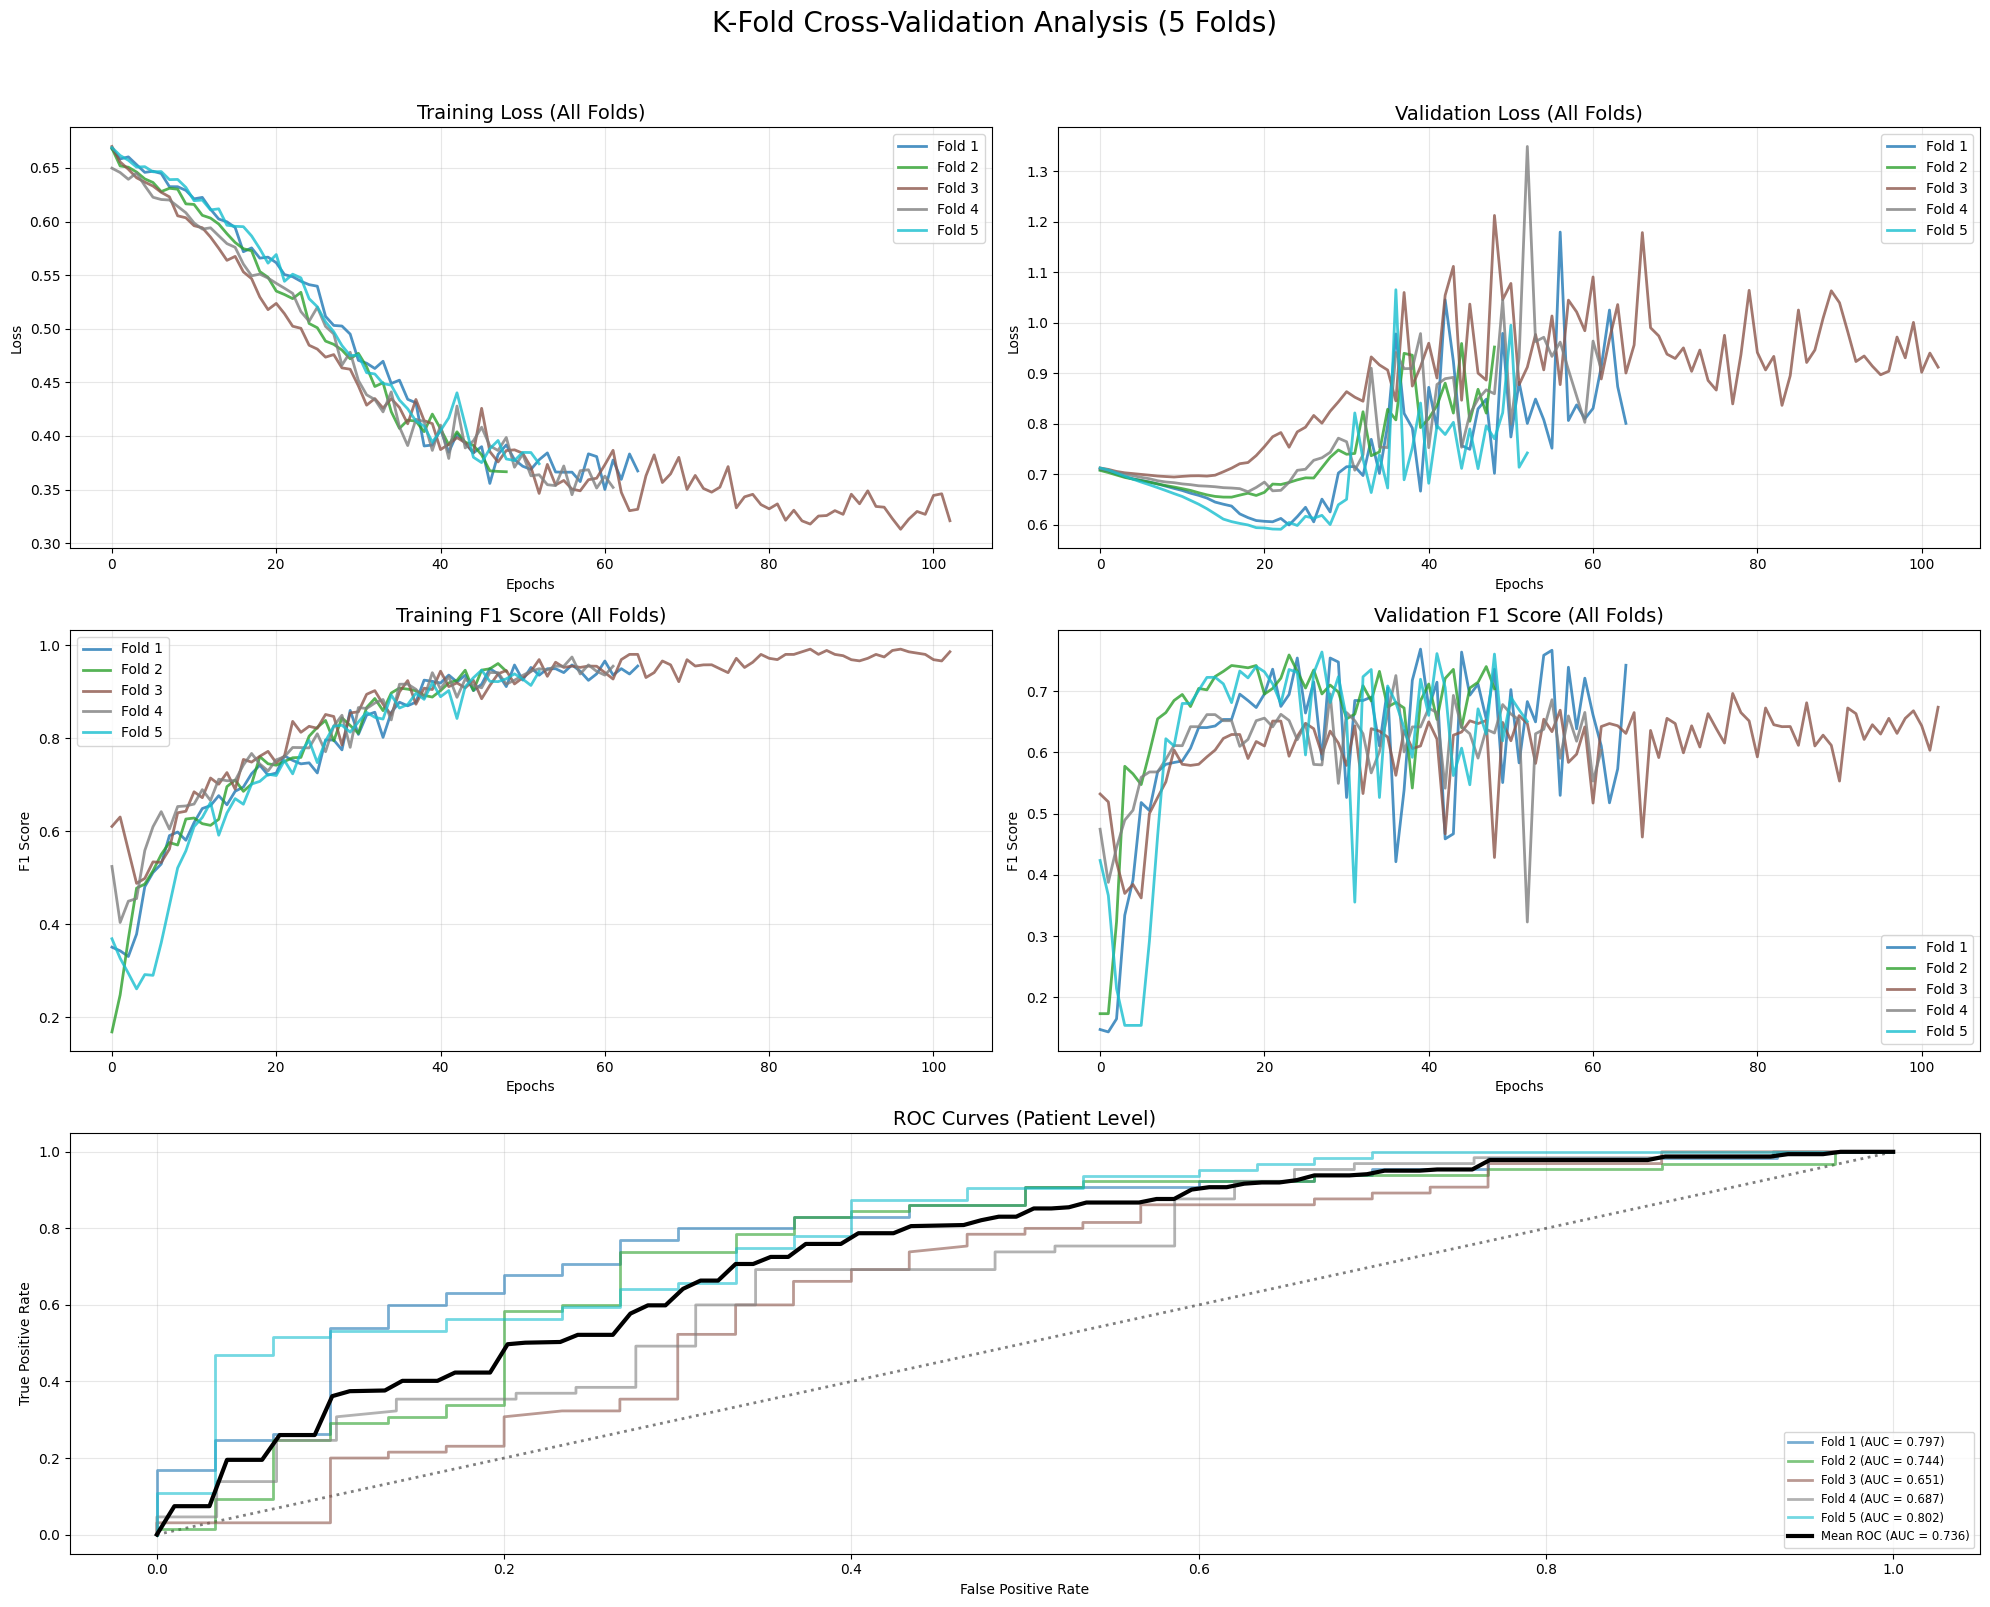


Plotting advanced metrics on out-of-fold predictions...


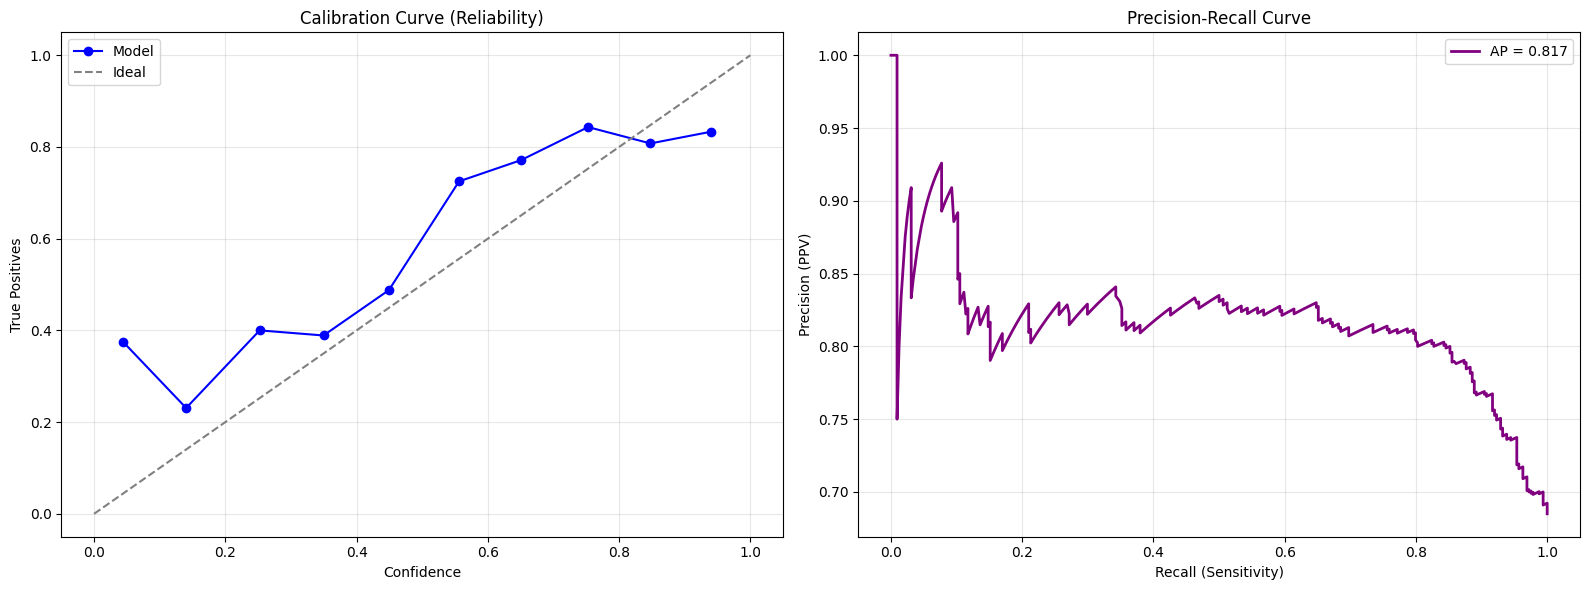


5. Evaluating on test set with ensemble...

TEST SET EVALUATION WITH ENSEMBLE AVERAGING
Test dataset: 53 segments from 53 patients

Loading 5 trained models for ensemble...
  ✓ Fold 1: Loaded ./models_beat_ensemble/fold_1_model.pt
  ✓ Fold 2: Loaded ./models_beat_ensemble/fold_2_model.pt
  ✓ Fold 3: Loaded ./models_beat_ensemble/fold_3_model.pt
  ✓ Fold 4: Loaded ./models_beat_ensemble/fold_4_model.pt
  ✓ Fold 5: Loaded ./models_beat_ensemble/fold_5_model.pt

Ensemble weights: [0.2 0.2 0.2 0.2 0.2]

FINAL RESULTS ON TEST SET
F1 Score (Weighted):     0.7338
Accuracy:                0.7547
Recall (Weighted):       0.7547
Precision (Weighted):    0.7458
ROC AUC:                 0.7271

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.70      0.41      0.52        17
     Class 1       0.77      0.92      0.84        36

    accuracy                           0.75        53
   macro avg       0.73      0.66      0.68        53
weighted av

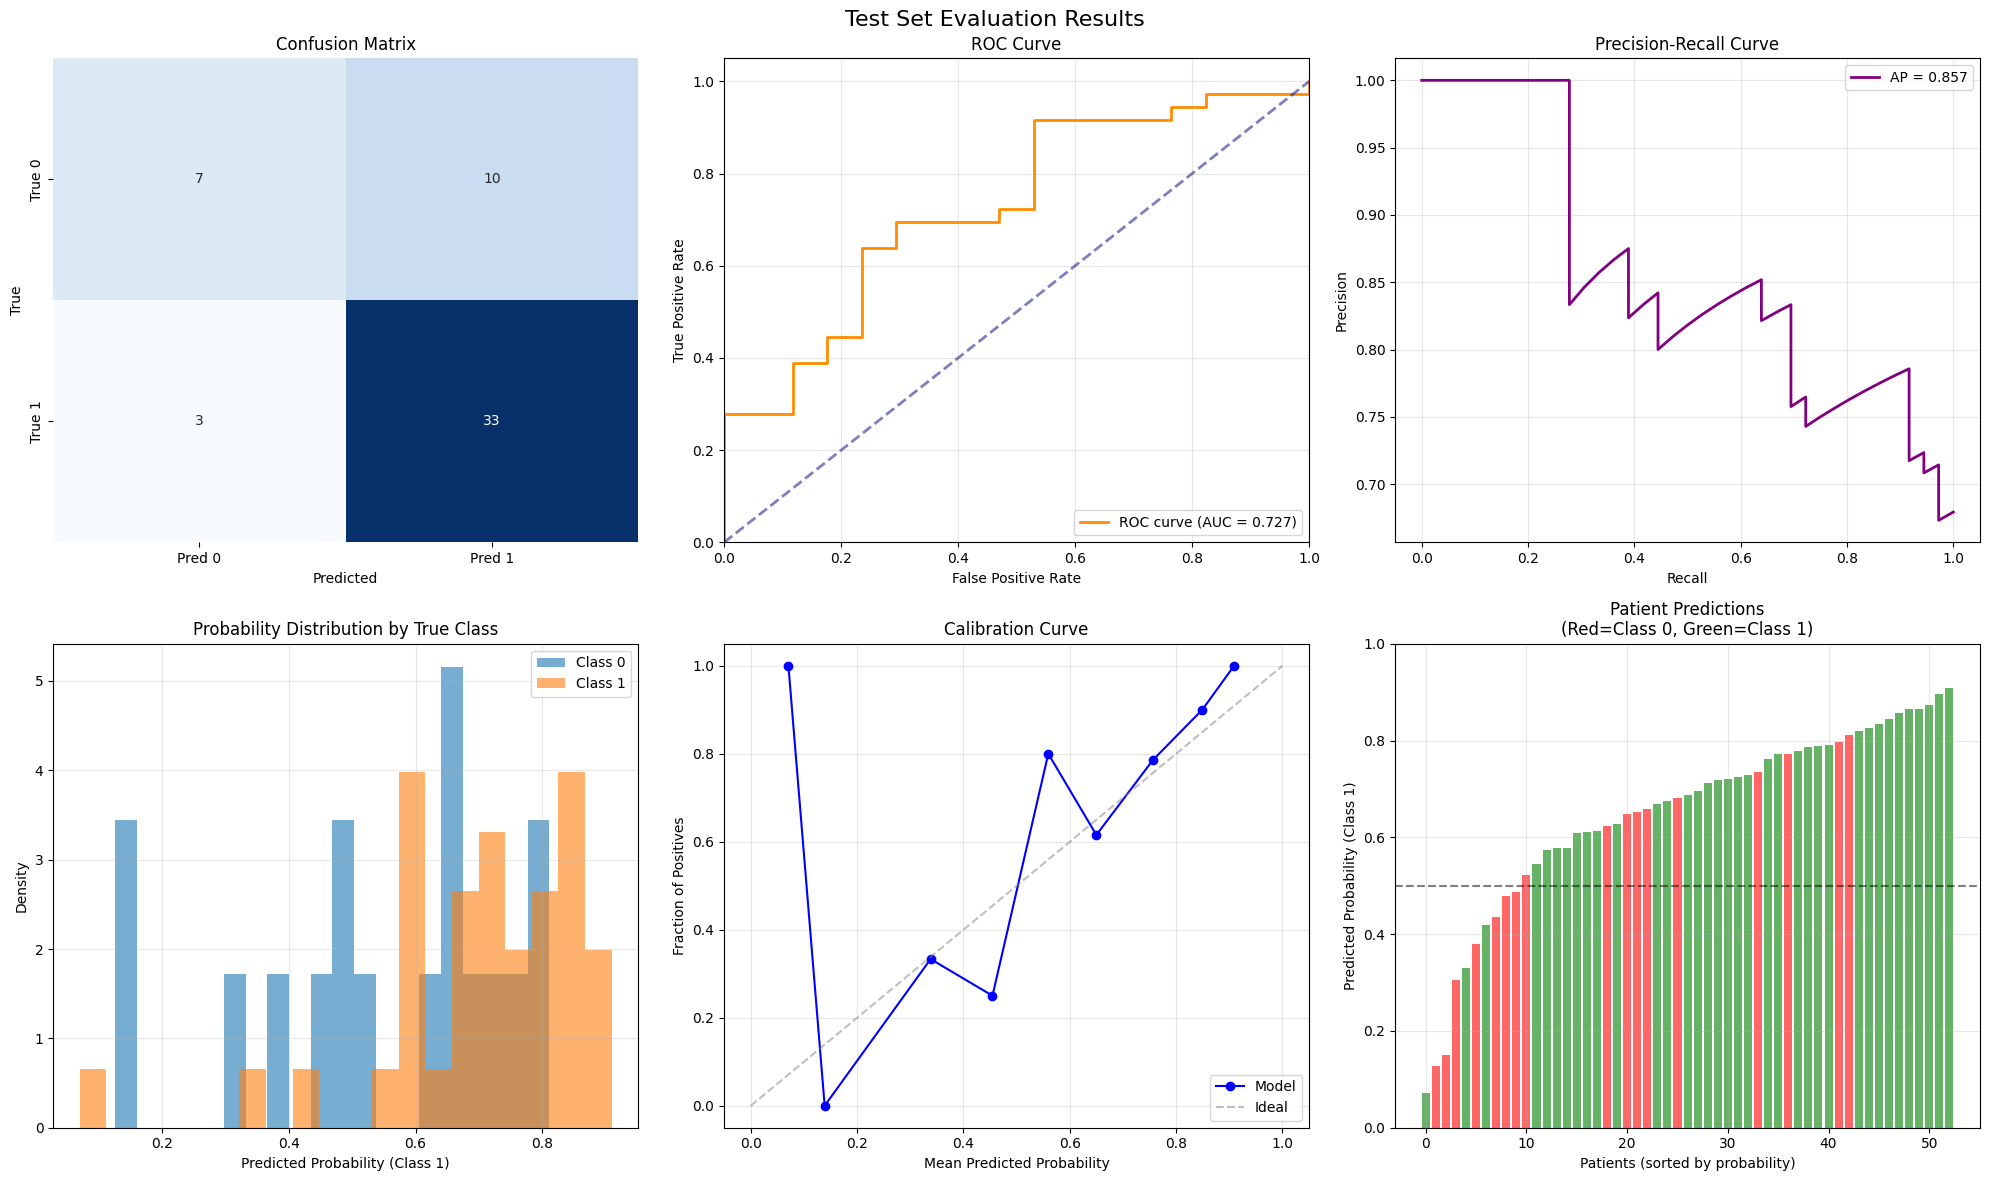


TEST SET PERFORMANCE METRICS
   Metric  Value
 F1 Score 0.7338
 Accuracy 0.7547
  ROC AUC 0.7271
Precision 0.7458
   Recall 0.7547

Class Distribution:
  Class 0: 17 patients (32.1%)
  Class 1: 36 patients (67.9%)

PIPELINE COMPLETED SUCCESSFULLY

CROSS-VALIDATION (Training Set):
  Mean F1: 0.7425 ± 0.0277
  Individual fold F1 scores: ['0.7684', '0.7589', '0.6961', '0.7253', '0.7637']

TEST SET RESULTS:
  F1 Score: 0.7338
  Accuracy: 0.7547

✓ Good generalization: Test performance is close to CV performance
  Difference: 0.0087

ANALYSIS COMPLETE - ALL VISUALIZATIONS DISPLAYED

Results saved to 'ecg_classification_results_full.pkl'

SUMMARY STATISTICS:
----------------------------------------
Cross-Validation Performance:
  Mean F1: 0.7425
  Std F1: 0.0277
  ROC AUC: 0.7221

Test Set Performance:
  F1 Score: 0.7338
  Accuracy: 0.7547
  ROC AUC: 0.7271


In [103]:
# ============================================================================
# 12. MAIN EXECUTION WITH ALL VISUALIZATIONS
# ============================================================================

if __name__ == "__main__":
    # Set your data path
    PATH = "/content/drive/MyDrive/WP_02_data/"  # Update this path

    try:
        print("Starting ECG Classification Pipeline...")
        print(f"Working directory: {os.getcwd()}")
        print(f"Data path: {PATH}")

        # Run complete pipeline with all visualizations
        results = complete_pipeline_with_test_split_final(
            path=PATH,
            test_size=0.1,  # 10% for test
            use_multiple_beats=False  # Start with simple version
        )

        print("\n" + "="*60)
        print("ANALYSIS COMPLETE - ALL VISUALIZATIONS DISPLAYED")
        print("="*60)

        # Optional: Save results
        import pickle
        results_file = 'ecg_classification_results_full.pkl'
        with open(results_file, 'wb') as f:
            pickle.dump(results, f)
        print(f"\nResults saved to '{results_file}'")

        # Print summary statistics
        print("\nSUMMARY STATISTICS:")
        print("-" * 40)

        # Training statistics
        train_data = results['fold_results']
        print(f"Cross-Validation Performance:")
        print(f"  Mean F1: {np.mean(train_data['fold_scores']):.4f}")
        print(f"  Std F1: {np.std(train_data['fold_scores']):.4f}")
        print(f"  ROC AUC: {roc_auc_score(train_data['oof_targets'], train_data['oof_probs']):.4f}")

        # Test statistics
        test_data = results['test_results']
        print(f"\nTest Set Performance:")
        print(f"  F1 Score: {test_data['metrics']['f1']:.4f}")
        print(f"  Accuracy: {test_data['metrics']['accuracy']:.4f}")
        print(f"  ROC AUC: {test_data['metrics']['roc_auc']:.4f}")

    except FileNotFoundError as e:
        print(f"\n❌ FILE NOT FOUND ERROR: {str(e)}")
        print("Please check if:")
        print("1. The data path is correct")
        print("2. All required files exist in the directory")
        print("3. You have permission to access the files")

    except ImportError as e:
        print(f"\n❌ IMPORT ERROR: {str(e)}")
        print("Please install missing packages:")
        print("pip install torch scikit-learn scipy pandas numpy matplotlib seaborn tqdm")

    except Exception as e:
        print(f"\n❌ UNEXPECTED ERROR: {str(e)}")
        print("\nDebugging information:")
        import traceback
        traceback.print_exc()

        print("\nTroubleshooting steps:")
        print("1. Check if all dependencies are installed")
        print("2. Verify the data path and file structure")
        print("3. Reduce batch size if running out of memory")
        print("4. Try with use_multiple_beats=False first")

In [104]:
# After the simple version works, try with multiple beats
results = complete_pipeline_with_test_split(
    path=PATH,
    test_size=0.1,
    use_multiple_beats=True  # Multiple beats for data augmentation
)

COMPLETE ECG CLASSIFICATION PIPELINE

1. Loading and preprocessing data...
Loading data and extracting beat morphologies...
Processing ECG signals and extracting beat morphologies...


Batch 2: 100%|██████████| 335/335 [00:08<00:00, 40.92it/s]



Data shapes:
  Representative beats: (526, 12, 600)
  Tabular features: (526, 9)
  Labels: (526,)

2. Splitting data into train and test sets...
  Training patients: 473
  Test patients: 53

3. Creating train and test datasets...
  Training samples: 473
  Test samples: 53

4. Running K-fold cross-validation on training set...
Using device: cuda

Starting 5-fold cross-validation with beat morphologies...
Using multiple beats

======================================== FOLD 1/5 ========================================
  Training samples: 2070
  Validation samples: 95
Start Training: 200 epochs on cuda...

Epoch   1/200 | Train Loss: 0.6942 F1: 0.3715 | Val Loss: 0.9380 F1: 0.1516 | LR: 0.000025
Epoch  10/200 | Train Loss: 0.5864 F1: 0.7296 | Val Loss: 4.5852 F1: 0.2109 | LR: 0.000043
Epoch  20/200 | Train Loss: 0.5033 F1: 0.8278 | Val Loss: 4.6355 F1: 0.3761 | LR: 0.000093
Epoch  30/200 | Train Loss: 0.4398 F1: 0.8975 | Val Loss: 6.2747 F1: 0.2109 | LR: 0.000171
Epoch  40/200 | Train Loss

ValueError: too many values to unpack (expected 4)